# Exploring NOAA API to get ground observations data

API Documentation: https://www.ncdc.noaa.gov/cdo-web/webservices/v2

In [1]:
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point
import folium
import requests as r
import pandas as pd
from folium import plugins as fplugins
import matplotlib.pyplot as plt
import json

In [2]:
headers = json.load(open('token.json'))

### token.json

```json
{
    "token": "#######"
}

```

## Get location ids

In [3]:
params = {
    'limit': 1000,
    'locationcategoryid': 'CNTRY'
}

In [4]:
req = r.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/locations', 
            headers=headers,
            params=params)

In [5]:
locationsdf = pd.DataFrame.from_records(req.json()['results'])

In [6]:
himat_loc = locationsdf[(locationsdf['name'] == 'China') \
            | (locationsdf['name'] == 'India') \
            | (locationsdf['name'] == 'Nepal') \
            | (locationsdf['name'] == 'Afghanistan') \
            | (locationsdf['name'] == 'Bhutan') \
            | (locationsdf['name'] == 'Tajikistan') \
            | (locationsdf['name'] == 'Kyrgyzstan') \
            | (locationsdf['name'] == 'Pakistan')].reset_index(drop='index')

In [7]:
himat_loc

,datacoverage,id,maxdate,mindate,name
0,1.0000,FIPS:AF,2017-10-01,1898-09-01,Afghanistan
1,0.9927,FIPS:BT,1957-12-31,1901-01-01,Bhutan
2,1.0000,FIPS:CH,2017-10-01,1881-01-01,China
3,1.0000,FIPS:IN,2017-10-01,1901-01-01,India
4,1.0000,FIPS:KG,2017-10-01,1881-09-01,Kyrgyzstan
5,1.0000,FIPS:NP,2017-10-01,1903-02-01,Nepal
6,1.0000,FIPS:PK,2017-10-01,1901-01-01,Pakistan
7,1.0000,FIPS:TI,2017-10-01,1895-01-01,Tajikistan


In [8]:
def get_stations_layer(name, locationid):
    params = {
        'locationid' : locationid,
        'limit': 1000
    }
    
    req = r.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/stations', 
            headers=headers,
            params=params)
    
    df = pd.DataFrame.from_records(req.json()['results'])
    geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs={'init': 'epsg:4326'})
    marker_cluster = fplugins.MarkerCluster(name='noaa_{}'.format(name))
    for idx, loc in gdf.iterrows():
        folium.Marker(
            location=[loc['latitude'], loc['longitude']],
            popup='<h4>{0}</h4><p>Elevation: {3}</p><p>Data range: {1} to {2}</p>'.format(loc['id'],
                                                                                          loc['mindate'],
                                                                                          loc['maxdate'],
                                                                                          loc['elevation'])).add_to(marker_cluster)
        
    return marker_cluster

In [9]:
def add_all_locations(m):
    for idx, val in himat_loc.iterrows():
        loc_id = val['id']
        af_layer = get_stations_layer(val['name'], loc_id)
        af_layer.add_to(m)

In [10]:
m = folium.Map([30.75, 76.00], zoom_start=5)

In [11]:
add_all_locations(m)

In [12]:
folium.LayerControl().add_to(m)

In [13]:
m

In [14]:
m.save('himat_noaa_stations.html')

## Datasets

In [15]:
params = {
    'limit': 1000
}
req = r.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets', 
            headers=headers,
            params=params)

In [16]:
datasetsdf = pd.DataFrame.from_records(req.json()['results'])

Below is a listing of the various datasettype that are available

In [17]:
datasetsdf

,datacoverage,id,maxdate,mindate,name,uid
0,1.00,GHCND,2017-10-03,1763-01-01,Daily Summaries,gov.noaa.ncdc:C00861
1,1.00,GSOM,2017-09-01,1763-01-01,Global Summary of the Month,gov.noaa.ncdc:C00946
2,1.00,GSOY,2017-01-01,1763-01-01,Global Summary of the Year,gov.noaa.ncdc:C00947
3,0.95,NEXRAD2,2017-10-04,1991-06-05,Weather Radar (Level II),gov.noaa.ncdc:C00345
4,0.95,NEXRAD3,2017-10-01,1994-05-20,Weather Radar (Level III),gov.noaa.ncdc:C00708
5,1.00,NORMAL_ANN,2010-01-01,2010-01-01,Normals Annual/Seasonal,gov.noaa.ncdc:C00821
6,1.00,NORMAL_DLY,2010-12-31,2010-01-01,Normals Daily,gov.noaa.ncdc:C00823
7,1.00,NORMAL_HLY,2010-12-31,2010-01-01,Normals Hourly,gov.noaa.ncdc:C00824
8,1.00,NORMAL_MLY,2010-12-01,2010-01-01,Normals Monthly,gov.noaa.ncdc:C00822
9,0.25,PRECIP_15,2014-01-01,1970-05-12,Precipitation 15 Minute,gov.noaa.ncdc:C00505


### Data type

In [18]:
params = {
    'limit': 1000,
    'datasetid': 'GHCND'
}
req = r.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/datatypes', 
            headers=headers,
            params=params)

In [19]:
datatypesdf = pd.DataFrame.from_records(req.json()['results'])

In [20]:
datatypesdf[datatypesdf['id'] == 'PRCP']

,datacoverage,id,maxdate,mindate,name
27,1.0,PRCP,2017-10-02,1781-01-01,Precipitation


## Get Data from a station

For a sample, we are getting Daily Summaries data for 

GHCND:CHM00055228

Elevation: 4280.0

Data range: 1962-01-01 to 2017-10-01

In [21]:
params = {
    'datasetid': 'GHCND',
    'stationid': 'GHCND:CHM00055228',
    'startdate': '2017-01-01',
    'enddate': '2017-10-01',
    'datatypeid': 'PRCP',
    'limit': 1000
}

In [22]:
req = r.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data', 
            headers=headers,
            params=params)

In [23]:
datadf = pd.DataFrame.from_records(req.json()['results'])

In [24]:
datadf.head()

,attributes,datatype,date,station,value
0,",,S,",PRCP,2017-02-06T00:00:00,GHCND:CHM00055228,5
1,",,S,",PRCP,2017-03-09T00:00:00,GHCND:CHM00055228,3
2,",,S,",PRCP,2017-03-10T00:00:00,GHCND:CHM00055228,0
3,",,S,",PRCP,2017-03-16T00:00:00,GHCND:CHM00055228,3
4,",,S,",PRCP,2017-03-17T00:00:00,GHCND:CHM00055228,3


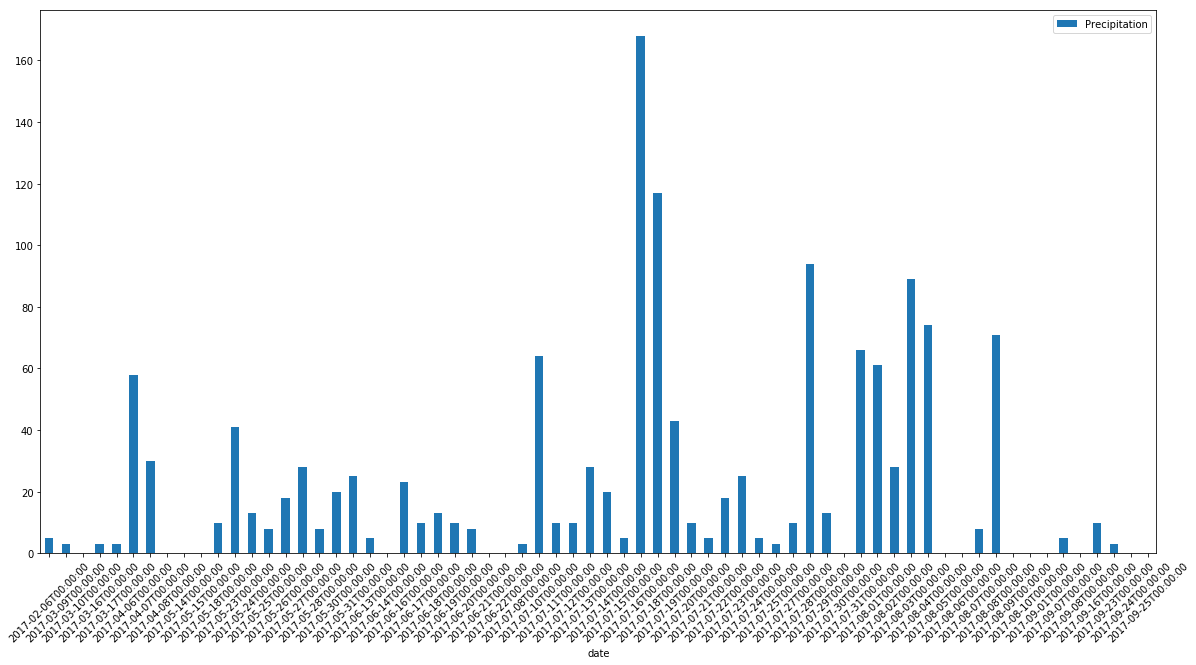

In [25]:
datadf.plot(x='date', y='value', rot=45, kind='bar', figsize=(20, 10), label='Precipitation')